# PCEC basic figures
This notebook generates figures that demonstrate hybrid measurements and DRT-DOP inversion using the protonic ceramic cell as a case study.

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from copy import deepcopy
import glob
from pathlib import Path
from scipy.optimize import least_squares
import time

import hybdrt
from hybdrt.models import DRT
from hybdrt.models.sequential import fit_sequence
import hybdrt.fileload as fl
import hybdrt.plotting as hplt
import hybdrt.preprocessing as pp
from hybdrt.evaluation import DrtScorer, calculate_reg_metrics

import fig_funcs as ff

%load_ext autoreload
%autoreload 2

In [3]:
# Set plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

ff.set_plotdir('./figures')

# Cell area
d_cell = 0.25
a_cell = np.pi * (d_cell * 2.54/ 2) ** 2

In [4]:
# Check data files
datadir = Path('../data/PCEC/basic')
os.listdir(datadir)

['CHRONOP_Chrono_Pulse_tstep=1.5_Iac=5.1mA.DTA',
 'CHRONOP_Chrono_Pulse_tstep=1.5_Iac=5.1mA_2.DTA',
 'CHRONOP_Hybrid_Geo_2sps_tstep=1.5s.DTA',
 'CHRONOP_Hybrid_Geo_2sps_tstep=1.5s_endAtInit.DTA',
 'CHRONOP_Hybrid_Geo_2sps_tstep=1.5s_endAtInit_Iac=5.1mA.DTA',
 'EISGALV_Hybrid_Geo_2sps_tstep=1.5s.DTA',
 'EISGALV_Hybrid_Geo_2sps_tstep=1.5s_endAtInit.DTA',
 'EISGALV_Hybrid_Geo_2sps_tstep=1.5s_endAtInit_Iac=5.1mA.DTA',
 'EISPOT_10ppd_Post.DTA',
 'EISPOT_10ppd_pre.DTA']

## Validate hybrid technique against conventional EIS
Compare hybrid inversion results to conventional EIS.

In [5]:
# Create DRT instances for fitting
eis_drt = DRT(fit_dop=True, fixed_basis_nu=np.linspace(0.4, 1, 25), fit_inductance=False)
hy_drt = deepcopy(eis_drt)

# Set DOP regularization strength for 10:1 regularization ratio
dop_l2_lambda_0 = 10

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [6]:
# Fit conventional EIS data
full_eis_file = datadir.joinpath('EISPOT_10ppd_post.DTA')
full_eis_tup = fl.get_eis_tuple(full_eis_file)

eis_drt.fit_inductance = False
eis_drt.fit_dop = True
eis_drt.fit_eis(*full_eis_tup, iw_l2_lambda_0=1e-6, nonneg=True, dop_l2_lambda_0=dop_l2_lambda_0)

eis_drt_5ppd = deepcopy(eis_drt)
eis_drt_5ppd.fit_eis(full_eis_tup[0][::2], full_eis_tup[1][::2], iw_l2_lambda_0=1e-6, nonneg=True,
                     dop_l2_lambda_0=dop_l2_lambda_0)

full_eis_file2 = datadir.joinpath('EISPOT_10ppd_pre.DTA')
eis_tup2 = fl.read_eis(full_eis_file2, return_tuple=True)
freq2, z_meas2 = eis_tup2
eis_drt2 = deepcopy(eis_drt)
eis_drt2.fit_eis(*eis_tup2, iw_l2_lambda_0=1e-6, nonneg=True, dop_l2_lambda_0=dop_l2_lambda_0)

In [7]:
# Fit hybrid data
hy_suf_list = [
    'Hybrid_Geo_2sps_tstep=1.5s',
    'Hybrid_Geo_2sps_tstep=1.5s_endAtInit',
    'Hybrid_Geo_2sps_tstep=1.5s_endAtInit_Iac=5.1mA',
]

hy_cp_data = []
hy_fits = {'raw': [], 'bkg': []}
fit_kw = dict(
    # Downsample to 1000 chrono data points
    downsample=True, 
    downsample_kw={
      'method': 'decimate',
      'decimation_factor': 1.5,
       'target_size': 1000,
      'antialiased': True,
    },
    iw_l2_lambda_0=1e-6,
    vz_offset=True, vz_offset_eps=None,
    dop_l2_lambda_0=dop_l2_lambda_0
)

for hy_suffix in hy_suf_list:
    # Hybrid HFEIS measurements were collected in galvanostatic mode, 
    # but should have been collected in potentiostatic mode. 
    # To avoid differences introduced by the change in control mode,
    # we use the high-frequency portion of the 2nd independent PEIS measurement
    # for hybrid fits here. 
    # Since the hybrid fits are compared to the 1st PEIS measurement 
    # (and PEIS measurements are generally very consistent),
    # this should have minimal impact on the results.
    
    hy_eis_file = full_eis_file2
    hy_cp_file = datadir.joinpath(f'CHRONOP_{hy_suffix}.DTA')
    hy_cp_data.append(fl.read_chrono(hy_cp_file))
    hy_tup = fl.get_hybrid_tuple(hy_cp_file, hy_eis_file, min_freq=999)
    
    start_time = time.time()
    hy_drt.fit_hybrid(*hy_tup, **fit_kw)
    print('raw fit time: {:.2f} s'.format(time.time() - start_time))
    hy_fits['raw'].append(deepcopy(hy_drt))
    
    start_time = time.time()
    hy_drt.fit_hybrid(*hy_tup, **fit_kw, subtract_background=True, 
                      background_type='dynamic', background_corr_power=0.5)
    print('bkg fit time: {:.2f} s'.format(time.time() - start_time))
    hy_fits['bkg'].append(deepcopy(hy_drt))

16


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


raw fit time: 4.76 s
16


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


linear downsample size: 69


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


16


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


bkg fit time: 4.91 s
12
raw fit time: 2.03 s
12


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


linear downsample size: 89


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


12


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


bkg fit time: 4.95 s
13
raw fit time: 3.38 s
13
linear downsample size: 67


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


13
bkg fit time: 5.40 s


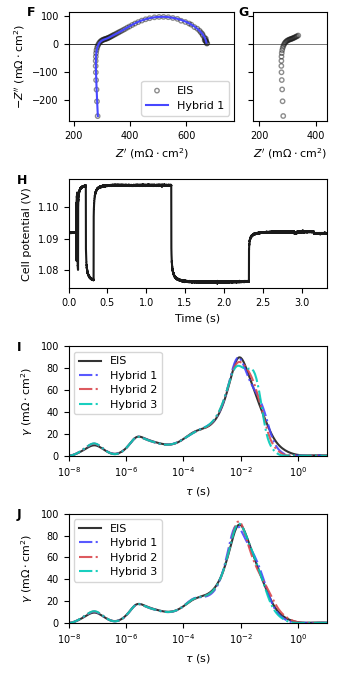

In [22]:
# Figure 1: Compare hybrid results to conventional EIS
fig = plt.figure(figsize=(0.5 * full_width, full_width))

gs = fig.add_gridspec(4, 3)

nyq_ax = fig.add_subplot(gs[0, :2])
hfz_ax = fig.add_subplot(gs[0, 2])
cp_ax = fig.add_subplot(gs[1, :])
drt_ax = fig.add_subplot(gs[2, :])
bkg_ax = fig.add_subplot(gs[3, :])

axes = [nyq_ax, hfz_ax, cp_ax, drt_ax, bkg_ax]

nyq_ax.get_shared_y_axes().join(nyq_ax, hfz_ax)

freq, z_eis = full_eis_tup
hf_index = hybdrt.utils.array.nearest_index(freq, 1000)
hplt.plot_nyquist((full_eis_tup[0], full_eis_tup[1]), ax=nyq_ax, **data_kw, label='EIS',
                  area=a_cell)

# Plot Hybrid EIS data
hplt.plot_nyquist((eis_tup2[0][:hf_index], eis_tup2[1][:hf_index]), ax=hfz_ax, 
                  **data_kw, area=a_cell)

hfz_ax.set_yticklabels([])
hfz_ax.set_ylabel('')

hplt.plot_chrono(hy_cp_data[2], axes=cp_ax, plot_i=False, plot_func='plot', 
                 c=data_kw['edgecolors'])
# hy_fits['bkg'][2].plot_chrono_correction(ax=cp_ax)
cp_ax.set_ylabel('Cell potential (V)')
cp_ax.set_xlim(0, hy_cp_data[2]['Time'].max())

# for key in ['EIS', 'Geo']:
#     fit = fits[key]
#     fit.plot_distribution(ax=drt_ax)
#     fit.plot_dop(ax=dop_ax, normalize=True, normalize_tau=(1e-5, 1e1))

for ax in [drt_ax, bkg_ax]:
    eis_drt.plot_distribution(ax=ax, c='k', ls='-', alpha=0.8, label='EIS', area=a_cell)
    ax.set_xlim(1e-8, 1e1)
    ax.set_ylim(0, 100)

for hy_index in range(3):
    hy_fits['raw'][hy_index].plot_distribution(ax=drt_ax, ls='-.', c=light_colors[hy_index],
                                               alpha=0.9,
                                               label=f'Hybrid {hy_index + 1}', 
                                               area=a_cell)
    hy_fits['bkg'][hy_index].plot_distribution(ax=bkg_ax, ls='-.', c=light_colors[hy_index], 
                                               alpha=0.9,
                                               label=f'Hybrid {hy_index + 1}',
                                               area=a_cell)

for ax in [drt_ax, bkg_ax]:
    ax.legend(labelspacing=0.4)
    

# drt_ax.text(0.97, 0.95, '$f_{{KL}}$: {:.3f}'.format(np.mean(drt_scores['raw'])), 
#             transform=drt_ax.transAxes, ha='right', va='top')
# bkg_ax.text(0.97, 0.95, '$f_{{KL}}$: {:.3f}'.format(np.mean(drt_scores['bkg'])), 
#             transform=bkg_ax.transAxes, ha='right', va='top')


z_hy = hy_fits['bkg'][0].predict_z(freq)
hplt.plot_nyquist((freq, z_hy), ax=nyq_ax, plot_func='plot', c=light_colors[0], label='Hybrid 1',
                  area=a_cell)

# nyq_ax.set_ylim(-150, 30)
hplt.set_nyquist_aspect(nyq_ax)
hplt.set_nyquist_aspect(hfz_ax, 'y')
xticks = [200, 400]
hfz_ax.set_xticks(xticks)
hfz_ax.set_xticklabels(xticks)

ff.add_letters(axes, start_index=5, loc=[(-0.25, 1.05)] + [(-0.2, 1.05)] * 4)

ff.savefig(fig, 'PCEC_hybrid_demo', ext='png')

In [9]:
# Check exp duration
zdf = fl.read_eis(hy_eis_file)
t_full = zdf['Time'].max()
t_eis = zdf.loc[zdf['Freq'] > 999, 'Time'].max()
for i, cdf in enumerate(hy_cp_data):
    t_cp = cdf['Time'].max()
    t_hyb = t_eis + t_cp
    print(t_eis, t_cp, t_hyb, t_full / t_hyb)

9.450233 3.4331 12.883333 17.978732677328143
9.450233 4.4331 13.883333 16.68374589876941
9.450233 3.3221 12.772333 18.134979725317216


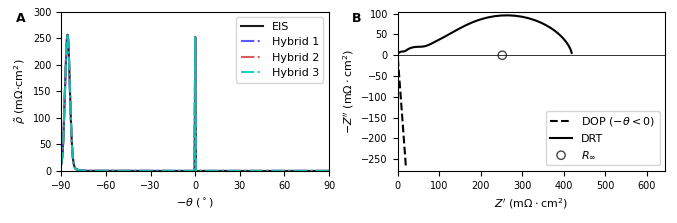

In [23]:
# Supp fig: Show DOP
fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.33))

# Normalize based on measured frequency range
norm_tau = (1 / (2 * np.pi * 1e6), 1 / (2 * np.pi * 1e-1))
dop_kw = dict(
    scale_prefix='m', normalize=True,
    normalize_tau=norm_tau,
    area=a_cell
)
eis_drt.plot_dop(ax=axes[0], c=data_kw['edgecolors'], label='EIS',
                **dop_kw
                )

for hy_index in range(3):
    hy_fits['bkg'][hy_index].plot_dop(
        ax=axes[0], ls='-.', c=light_colors[hy_index], 
        alpha=0.9, label=f'Hybrid {hy_index + 1}',
        **dop_kw
    )
    
axes[0].legend()

drt_rc = eis_drt.copy()
drt_pos = eis_drt.copy()
drt_rc.fit_parameters['x_dop'] = np.zeros_like(drt_rc.fit_parameters['x_dop'])
drt_pos.fit_parameters['x'] = np.zeros_like(drt_rc.fit_parameters['x'])

for drt_i in [drt_pos, drt_rc]:
    drt_i.fit_parameters['R_inf'] = 0

drt_pos.plot_eis_fit(axes=axes[1], plot_data=False, scale_prefix='m', ls='--',
                    label=r'DOP ($-\theta < 0$)', area=a_cell)
drt_rc.plot_eis_fit(frequencies=np.logspace(7, -1, 81), axes=axes[1], plot_data=False, scale_prefix='m', ls='-',
                   label='DRT', area=a_cell)
axes[1].scatter([1000 * eis_drt.predict_r_inf() * a_cell], [0], label='$R_{\infty}$', **data_kw, alpha=0.8)

axes[0].set_xlim(-90, 90)
axes[0].set_xticks(np.arange(-90, 90.1, 30))
axes[0].set_ylim(0, 300)

axes[1].legend()


ff.add_letters(axes, loc=(-0.17, 1))
ff.savefig(fig, 'Supp_PCEC_HybridDOP')

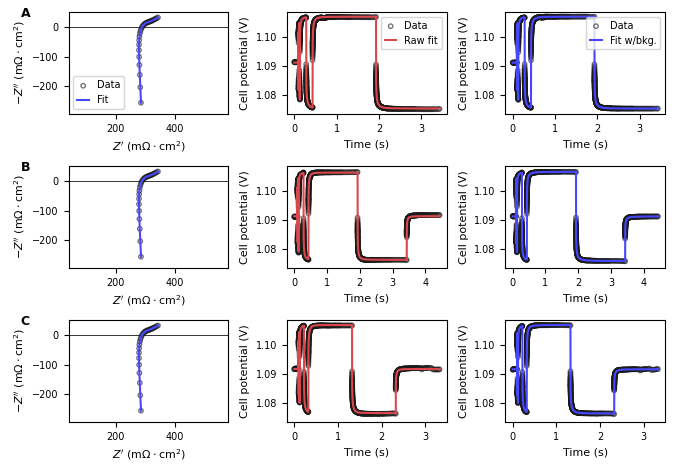

In [18]:
# Supp fig: show hybrid fits
fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.7))

axes[0, 0].get_shared_x_axes().join(*axes[:, 0])
axes[0, 0].get_shared_y_axes().join(*axes[:, 0])

# axes[0, 1].get_shared_x_axes().join(*axes[:, 1:].ravel())
axes[0, 1].get_shared_y_axes().join(*axes[:, 1:].ravel())

plot_kw = dict(
    data_kw=data_kw | {'alpha': 0.6},
)
for i in range(3):
    raw_fit = hy_fits['raw'][i]
    bkg_fit = hy_fits['bkg'][i]
    
    bkg_fit.plot_eis_fit(axes=axes[i, 0], c=light_colors[0], label='Fit', data_label='Data',
                         **plot_kw, area=a_cell)
    bkg_fit.plot_chrono_fit(ax=axes[i, 2], transform_time=False, 
                            c=light_colors[0], data_label='Data', label='Fit w/bkg.',
                            **plot_kw)
    raw_fit.plot_chrono_fit(ax=axes[i, 1], transform_time=False, 
                            c=light_colors[1], data_label='Data', label='Raw fit',
                            **plot_kw)
    

for ax in axes[0]:
    ax.legend(fontsize=7, handlelength=1.2)

for ax in axes[:, 1:].ravel():
    ax.set_ylabel('Cell potential (V)')
    
for ax in axes[1:, 0]:
    ax.get_legend().remove()


fig.tight_layout()

# Reset aspect ratio
hplt.set_nyquist_aspect(axes[0, 0])

ff.add_letters(axes[:, 0], loc=(-0.3, 1.05))
ff.savefig(fig, 'Supp_PCEC_HybridFits')

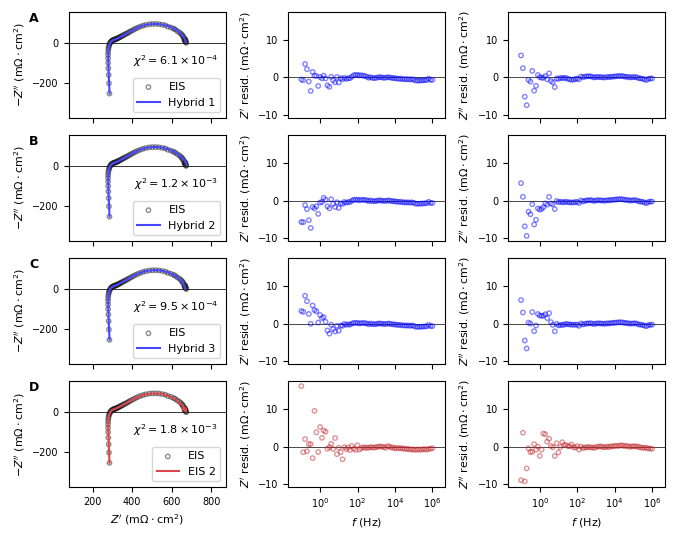

In [20]:
# Supp fig: Compare hybrid recovered impedance to measured impedance

fig, axes = plt.subplots(4, 3, figsize=(full_width, full_width * 0.8))

axes[0, 0].get_shared_x_axes().join(*axes[:, 0].ravel())
axes[0, 0].get_shared_y_axes().join(*axes[:, 0].ravel())

axes[0, 1].get_shared_x_axes().join(*axes[:, 1:].ravel())
axes[0, 1].get_shared_y_axes().join(*axes[:, 1:].ravel())

freq, z_meas = full_eis_tup
for i in range(3):
    z_pred = hy_fits['bkg'][i].predict_z(freq)
    hplt.plot_nyquist(full_eis_tup, ax=axes[i, 0], **data_kw, alpha=0.5, label='EIS', area=a_cell)
    hplt.plot_nyquist((freq, z_pred), ax=axes[i, 0], plot_func='plot', c=light_colors[0],
                     label=f'Hybrid {i + 1}', area=a_cell)
    
    z_err = z_meas - z_pred
    hplt.plot_bode((freq, z_err), axes=axes[i, 1:], cols=['Zreal', 'Zimag'], edgecolors=base_colors[0],
                   facecolors='none', area=a_cell
                  )
    
    chi_sq = hybdrt.evaluation.chi_sq(z_meas, z_pred, weights=1 / np.abs(z_meas))
    pwr = np.floor(np.log10(chi_sq))
    axes[i, 0].text(0.95, 0.5, r'$\chi^2={:.1f} \times 10^{{{:.0f}}}$'.format(chi_sq / 10 ** pwr, pwr), 
                    transform=axes[i, 0].transAxes, 
                    ha='right')
    
# Compare to repeated EIS measurement
hplt.plot_nyquist(full_eis_tup, ax=axes[3, 0], **data_kw, alpha=0.5, label='EIS', area=a_cell)
hplt.plot_nyquist(eis_tup2, ax=axes[3, 0], plot_func='plot', label='EIS 2', c=light_colors[1], area=a_cell)

z_err = z_meas - eis_tup2[1]
hplt.plot_bode((freq, z_err), axes=axes[3, 1:], cols=['Zreal', 'Zimag'],
              edgecolors=base_colors[1], facecolors='none', area=a_cell)

chi_sq = hybdrt.evaluation.chi_sq(z_meas, eis_tup2[1], weights=1 / np.abs(z_meas))
pwr = np.floor(np.log10(chi_sq))
axes[3, 0].text(0.95, 0.5, r'$\chi^2={:.1f} \times 10^{{{:.0f}}}$'.format(chi_sq / 10 ** pwr, pwr), 
                transform=axes[3, 0].transAxes, 
                ha='right')

for ax in axes[:3].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
for ax in axes[:, 1:].ravel():
    ax.axhline(0, c='k', lw=0.5, zorder=-10)
    
for ax in axes[:, 1]:
    ax.set_ylabel('$Z^{\prime}$ resid. (m$\Omega \cdot \mathrm{cm}^2$)')
    
for ax in axes[:, 2]:
    ax.set_ylabel('$Z^{\prime\prime}$ resid. (m$\Omega \cdot \mathrm{cm}^2$)')

fig.tight_layout()

# Reset Nyquist aspect ratio after tight_layout()
hplt.set_nyquist_aspect(axes[0, 0])

ff.add_letters(axes[:, 0])
ff.savefig(fig, 'Supp_PCEC_Hybrid-Z-Validation')

## Illustrate background subtraction

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\plotting.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:4373: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:4733: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


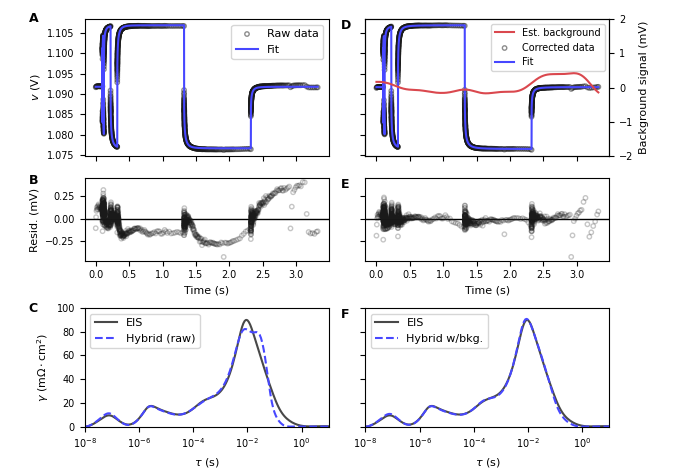

In [21]:
# Supp fig: Show background subtraction

fig = plt.figure(figsize=(full_width, full_width * 0.7))
gs1 = fig.add_gridspec(2, 2, height_ratios=(1, 0.6), top=0.96, bottom=0.45, wspace=0.15)
gs2 = fig.add_gridspec(1, 2, top=0.35, wspace=0.15, bottom=0.1)
axes = []
for i in range(gs1.nrows):
    axes.append([fig.add_subplot(gs1[i, j]) for j in range(gs1.ncols)])
axes.append([fig.add_subplot(gs2[i]) for i in range(gs2.ncols)])    
axes = np.array(axes)

axes[0, 0].get_shared_x_axes().join(*axes.ravel()[:4])
for i in range(3):
    axes[i, 0].get_shared_y_axes().join(*axes[i])


hy_index = 2
raw_fit = hy_fits['raw'][hy_index]
bkg_fit = hy_fits['bkg'][hy_index]

t = bkg_fit.get_fit_times()
v_raw = bkg_fit.raw_response_signal
v_bkg = bkg_fit.raw_response_background
v_base = bkg_fit.fit_parameters['v_baseline']

raw_fit.plot_chrono_fit(ax=axes[0, 0], transform_time=False, data_kw=data_kw, c=light_colors[0],
                       data_label='Raw data', label='Fit')
axes[0, 0].legend()
# axes[0, 0].plot(t, v_raw, color=data_kw['edgecolors'])
# axes[0, 0].scatter(t[::1], v_raw[::1], **data_kw, s=10, alpha=0.5)

# Plot fit with background estimation
ax2 = axes[0, 1].twinx()
ax2.plot(t, 1000 * v_bkg, c=light_colors[1], label='Est. background')
ax2.set_ylim(-2, 2)
ax2.set_ylabel('Background signal (mV)')
bkg_fit.plot_chrono_fit(ax=axes[0, 1], transform_time=False, data_kw=data_kw, c=light_colors[0],
                       data_label='Corrected data', label='Fit')
h, l = axes[0, 1].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
axes[0, 1].legend(handles=h2 + h, labels=l2 + l, fontsize=7)
axes[0, 1].set_ylabel('Cell potential (V)')

# Plot residuals
raw_fit.plot_chrono_residuals(ax=axes[1, 0], transform_time=False, 
                              scale_prefix='m', plot_sigma=False, **data_kw, alpha=0.25)
bkg_fit.plot_chrono_residuals(ax=axes[1, 1], transform_time=False, 
                              scale_prefix='m', plot_sigma=False, **data_kw, alpha=0.25)
axes[1, 0].set_ylabel('Resid. (mV)')

# Plot DRT comparison
for ax in axes[2]:
    eis_drt.plot_distribution(ax=ax, c=data_kw['edgecolors'], alpha=0.8, label='EIS',
                              area=a_cell)
    
raw_fit.plot_distribution(ax=axes[2, 0], c=light_colors[0], ls='--', label='Hybrid (raw)', area=a_cell)
bkg_fit.plot_distribution(ax=axes[2, 1], c=light_colors[0], ls='--', label='Hybrid w/bkg.', area=a_cell)

for ax in axes[0]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
for ax in axes[2]:
    ax.legend()
    ax.set_xlim(1e-8, 1e1)
    ax.set_ylim(0, 100)
    
for ax in axes[:, 1]:
    ax.set_ylabel('')
    ax.set_yticklabels([])


loci = [(-0.23, 1.05)] * 3 + [(-0.1, 1)] * 3
ff.add_letters(axes.T, loc=loci)

ff.savefig(fig, 'Supp_PCEC_BkgEstimation')

## Evaluate similarity metrics

In [ ]:
# Quantify match between EIS and hybrid
ds = DrtScorer()

match_scores = {}

f1, z1 = full_eis_tup
zmod = np.abs(z1)

# Get psi for manual eval
nu_eval = np.linspace(-1, 1, 101)
psi_eis = eis_drt.predict_dop(nu_eval, normalize=True, normalize_tau=norm_tau)

# Compare DRT and DOP
for i, fit in enumerate(hy_fits['raw'] + hy_fits['bkg'] + [eis_drt2]):
    num_hybrid = len(hy_fits['raw'])
    if i < num_hybrid:
        key = f'Hybrid {i + 1} (raw)'
    elif i < 2 * num_hybrid:
        key = f'Hybrid {i % num_hybrid + 1} (bkg.)'
    else:
        key = 'EIS 2'
    drt_scores = ds.evaluate_models(eis_drt, fit, tau_reg=np.logspace(-7, 3, 101), 
                                    tau_cls=np.logspace(-7, 3, 101))
    
    psi_compare = fit.predict_dop(nu_eval, normalize=True, normalize_tau=norm_tau)
    _, dop_scores = calculate_reg_metrics(np.exp(nu_eval), psi_eis, psi_compare, False)

#     print(key, drt_scores['r2'], dop_scores['f_kl'])
    match_scores[key] = {'DRT': drt_scores, 'DOP': dop_scores}

    # Compare impedance
    if key == 'EIS 2':
        z2 = fit.z_fit
    else:
        z2 = fit.predict_z(f1)
    match_scores[key]['Z'] = {'chi_sq': hybdrt.evaluation.chi_sq(z1, z2, weights=1 / zmod)}   

False
thresh: 0.007250680457552653
thresh: 0.007549252507994591
False
thresh: 0.007250680457552653
thresh: 0.007091473233255379
False
thresh: 0.007250680457552653
thresh: 0.008211164847685044
False
thresh: 0.007250680457552653
thresh: 0.007535635240145955
False
thresh: 0.007250680457552653
thresh: 0.007618927159715311
False
thresh: 0.007250680457552653
thresh: 0.007409181558269833
False
thresh: 0.007250680457552653
thresh: 0.007457244409230299


In [20]:
# Average metrics
for kind in ['raw', 'bkg.']:
    keys = [k for k, v in match_scores.items() if k.find(kind) > -1]
    key_tups = [('DRT', 'r2'), ('DOP', 'r2'), ('Z', 'chi_sq')]
    print(kind, ' & '.join(
        [str(np.round(np.mean([match_scores[key][key_tup[0]][key_tup[1]] for key in keys]), 5))
                 for key_tup in key_tups]
        )
    )

raw 0.98554 & 0.99996 & 0.00157
bkg. 0.99666 & 0.99992 & 0.00091


In [26]:
# Metrics for individual measurements
table_data = []
table_keys = []
for k, v in match_scores.items():
    if k[:6] == 'Hybrid':
        scores = match_scores[k]
        row_data = [scores['DRT']['r2'], scores['DOP']['r2'], scores['Z']['chi_sq']]
        table_data.append(row_data)
        table_keys.append(k)
        
# table_data = np.array(table_data)
ff.format_table(table_data, fmt='.3f')
table_keys

0.995 & 1.000 & 0.001\\
0.992 & 1.000 & 0.001\\
0.969 & 1.000 & 0.002\\
0.995 & 1.000 & 0.001\\
0.997 & 1.000 & 0.001\\
0.998 & 1.000 & 0.001


['Hybrid 1 (raw)',
 'Hybrid 2 (raw)',
 'Hybrid 3 (raw)',
 'Hybrid 1 (bkg.)',
 'Hybrid 2 (bkg.)',
 'Hybrid 3 (bkg.)']

In [27]:
# Get chi_sq values in sci notation
print('\n'.join([ff.sci_not(x, 1) for x in np.array(table_data)[:, -1]]))

$1.2 \times 10^{-3}$
$1.5 \times 10^{-3}$
$2.1 \times 10^{-3}$
$6.1 \times 10^{-4}$
$1.2 \times 10^{-3}$
$9.5 \times 10^{-4}$
